In [1]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install ortools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

import math
import random
from shapely.geometry import Point, Polygon

import itertools
import time

from ortools.sat.python import cp_model

%matplotlib inline

# Draw the actual map

In [4]:
class Regions:
    def __init__(self, path:str="."):
        # r_ refers to "region", wheres b_ refers to boolean
        self.__peru__ = gpd.read_file(f"{path}/peru_distrital_simple.geojson")
        self.__peru__.drop(self.__peru__.columns[[1, 2, 3, 7, 8, 9, 10]], axis=1, inplace=True)
        self.__b_provincia__ = False
        self.__b_distritos__ = False
        self.__b_prov_read__ = False

    def GetDepartamentos(self):
        return list( self.__peru__["NOMBDEP"].sort_values().unique() )

    def SetDeparmento(self, departamento:str):
        self.__dep_name__ = departamento

    def GetProvincias(self) -> list:
        if not self.__b_prov_read__:
            # self.__prov_names__ = list( self.__peru__["NOMBPROV"].sort_values().unique() )
            self.__prov_names__ = list( self.__peru__[self.__peru__["NOMBDEP"] == self.__dep_name__]["NOMBPROV"].sort_values().unique() )
            self.__b_prov_read__ = True
            return self.__prov_names__
        return self.__prov_names__

    def SetProvincia(self, provincia:str):
        self.__provincia__ = self.__peru__[self.__peru__["NOMBPROV"] == provincia]
        self.__provincia__: gpd.GeoDataFrame = self.__provincia__.sort_values(by="NOMBDIST")
        self.__prov_name__ = provincia
        self.__b_provincia__ = True

    def GetDistritos(self) -> list:
        if not self.__b_provincia__:
            print("SetProvincia has not been called")
            return
        return list( self.__provincia__["NOMBDIST"] )

    # selected: a list of booleans
    def SetDistritos(self, selected):
        if not self.__b_provincia__:
            print("SetProvincia has not been called")
            return
        # Only items that match True will be selected
        self.__distritos__: gpd.GeoDataFrame = self.__provincia__[selected]
        self.data = self.__distritos__
        self.__b_distritos__ = True

In [5]:
class People:
    def __init__(self, regions:Regions, path:str="."):
        self.__regions__ = regions
        self.__path__ = path
        self.__ReadReunisMetaData__()

    def __ReadReunisMetaData__(self):
        self.__reunis_meta__: pd.DataFrame = pd.read_csv(f"{self.__path__}/MetaPreprocessed.csv")
        # There are 9 categories of ages from [1;9] and with the following names
        age_group_names = ["5-11", "12-17", "18-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80 >"]
        self.__age_group_to_num__ = {e:(i+1) for i, e in enumerate(age_group_names)}

    def __UpdateReunisVacData__(self):
        # This dataset contain the numbers estimated to be achived
        r_selected_distritos = self.__regions__.data["NOMBDIST"]
        self.__prov_reunis_meta__ = self.__reunis_meta__[ self.__reunis_meta__["provincia"] == self.__regions__.__prov_name__ ]
        self.__dist_reunis_meta__ = self.__prov_reunis_meta__[ self.__prov_reunis_meta__["distrito"].isin(r_selected_distritos) ]
        # This dataset contains the numbers achived at the moment
        self.__reunis__ = pd.read_csv(f"{self.__path__}/VacunaCovid_Resumen/{self.__regions__.__dep_name__}.csv", parse_dates=["Fecha"])
        self.__prov_reunis__ = self.__reunis__[ self.__reunis__["Provincia"] == self.__regions__.__prov_name__ ]
        self.__dist_reunis__ = self.__prov_reunis__[ self.__prov_reunis__["Distrito"].isin(r_selected_distritos) ]

    def __GenerateLoc__(self, centralPoint, radius):
        r = radius * math.sqrt(random.random())
        theta = random.random() * 2 * math.pi

        cx, cy = centralPoint
        x = cx + r * math.cos(theta)
        y = cy + r * math.sin(theta)

        return (x, y)

    # 1. Location of people
    def SetLocation(self, percentage:float, radius=1e-2):
        self.__UpdateReunisVacData__()
        realDistributionByDistrito = list( self.__dist_reunis_meta__.groupby("distrito")["Meta_2022"].sum() )
        polygonsByDistrito = list( self.__regions__.data["geometry"] )

        realTotal = sum(realDistributionByDistrito)
        partTotal = (percentage * realTotal)
        # Convert to a proportion of that distribution
        k = (partTotal / realTotal)
        partDistribution = [int(e* k) for e in realDistributionByDistrito]

        # Get centroids of a polygon and generate coords
        locCentroids = [list(e.centroid.coords)[0] for e in polygonsByDistrito]
        locPeople = [[ self.__GenerateLoc__(loc, radius=radius) for _ in range(n) ] for loc, n in zip(locCentroids, partDistribution) ]
        locPeople = list( itertools.chain( *locPeople ) )
        self.__distribution_dist_real__, self.__distribution_dist_part__ = realDistributionByDistrito, partDistribution

        # Save the new data
        self.data, self.total = gpd.GeoDataFrame(geometry=gpd.points_from_xy(*zip(*locPeople))), len(locPeople)

    def GetAges(self):
        return list( self.__age_group_to_num__.keys() )

    # 2. Age of people
    def SetAge(self, ageLimit:str):
        self.ageLimitStr: str = ageLimit
        self.ageLimitInt: int = self.__age_group_to_num__[ageLimit]
        dist_reunis_meta = self.__dist_reunis_meta__

        #realDistributionByAge
        realDistributionBy9agesByDistrito = list( dist_reunis_meta.groupby(["distrito","Grupo Edad"])["Meta_2022"].sum() )
        percentages = [[ e/self.__distribution_dist_real__[i] for e in realDistributionBy9agesByDistrito[j:j+9]] for i, j in enumerate(range(0, len(self.__distribution_dist_real__)*9, 9))]

        # Save the new data
        agePeople = [ random.choices(range(1, 10), weights=w, k=n) for n, w in zip(self.__distribution_dist_part__, percentages) ] 
        self.data["ageGroup"] = list( itertools.chain( *agePeople ) )
        # Binarization and save
        self.data["ageAllowed"] = [(e >= self.ageLimitInt) for e in self.data["ageGroup"]]

    # 5. Number of doses 
    def SetDoses(self, dosesLimit:int=2, beforeDate=pd.Timestamp(2023, 1, 1)):
        # This part uses the dataset with vaccinated people, so we can filter to get only the data before certain date
        _date_filtered = self.__dist_reunis__[self.__dist_reunis__["Fecha"] <= beforeDate]
        _age_filtered= _date_filtered[ _date_filtered["Grupo Edad"] >= self.ageLimitInt ]

        dosesAcumByDistrito = [ list( _age_filtered[ _age_filtered["Tipo dosis"] == i ].groupby("Distrito")["Dosis"].sum() ) for i in range(5) ]
        totalByDistrito = list( self.__dist_reunis_meta__[ self.__dist_reunis_meta__["Grupo Edad"] >= self.ageLimitInt ].groupby("distrito")["Meta_2022"].sum() )

        # FIXING QUANTITIES
        dosesAcumByDistrito[0] = [(totalByDistrito[i]-dosesAcumByDistrito[1][i]) for i in range(len(totalByDistrito)) ]
        for i in range(1, 4):
            dosesAcumByDistrito[i] = [(dosesAcumByDistrito[i][j]-dosesAcumByDistrito[i+1][j]) for j in range(len(totalByDistrito))]

        percentages= [ [(dosesAcumByDistrito[d][i]/n) for d in range(5)] for i, n in enumerate(totalByDistrito) ]
        # Save the new data
        dosesPeople = [ random.choices(range(5), weights=w, k=n) for n, w in zip(self.__distribution_dist_part__, percentages) ] 
        self.data["dosesNumber"] = list( itertools.chain( *dosesPeople ) )
        # Binarization and save
        self.data["dosesCompleted"] = [(e >= dosesLimit) for e in self.data["dosesNumber"]]

    def SetInfected(self, probability:float=0.05):
        # The propability of infection may vary based on different factors
        rows_infected = random.choices( range(len( self.data )), k=int(len( self.data )*probability) )
        # Save the new data
        self.data["infected"] = [ i in rows_infected for i in self.data.index ]

    def GetLoc(self):
        return [(x,y) for x,y in zip(self.data.geometry.x , self.data.geometry.y)]

    def GetAge(self, asBoolean:bool):
        return list( self.data.ageAllowed if asBoolean else self.data.ageGroup )


In [6]:
class HealthCenters:
    def __init__(self, regions:Regions, path:str="."):
        self.__regions__ = regions
        centers = pd.read_csv(f"{path}/TB_CENTRO_VACUNACION.csv")
        self.__centers__: gpd.GeoDataFrame = gpd.GeoDataFrame(centers, geometry=gpd.points_from_xy(centers["longitud"], centers["latitud"]))
        self.b_selected_centers = False

    # 3. Location of centers (part 1: filter dataframe)
    def SetCenters(self):
        # local function
        polygonsByDistrito = list( self.__regions__.data["geometry"] )
        def is_in(point:Point):
            for polygon in polygonsByDistrito:
                if point.within(polygon):
                    return True
            return False
        # do the selection
        selected = [ is_in(p) for p in self.__centers__.geometry]   
        self.data = self.s_data = self.__centers__[selected]
        self.total = self.s_total = len(self.s_data)
        # validate the operation
        if self.total < 30:
            print("No enough centers to select (minimum 30)")
            return
        # set operation as done
        self.b_selected_centers = True

    # 3. Location of centers (part 2: reduce size (optional))
    def AsSample(self, percentage:float=0.0):
        if not self.b_selected_centers:
            print("select_centers has not been called")
            return
        # do the reduction
        temp = int(self.s_total * percentage)
        self.total = temp if temp > 29 or temp > self.s_total else 30
        self.data = self.s_data.sample(n=self.total)

    # 4. Capacity of center
    def SetCapacity(self, totalPeople, exceed=.5):
        if not self.b_selected_centers:
            print("select_centers has not been called")
            return
        # ADAPT CAPACITY
        # mean_capacity = int( (self.total * totalPeople / self.s_total ) * exceed)
        mean_capacity = int( (totalPeople / self.total) * exceed)
        # self.data["capacity"] = [ random.randint(10, 40) for _ in range(self.total) ]
        self.data["capacity"] = [ mean_capacity ] * self.total
        self.capacity = sum(self.data["capacity"])

    def GetLoc(self):
        return [(x,y) for x,y in zip(self.data["longitud"], self.data["latitud"])]


In [7]:
class AppLogic:
    def __init__(self, path:str="."):
        self.regions = Regions(path)
        self.hcs = HealthCenters(self.regions, path)
        self.people = People(self.regions, path)

    def Example1(self):
        # Conf Regions
        self.regions.SetDeparmento("LIMA")
        self.regions.SetProvincia("LIMA")
        _selected_bool = [False, False, False, False, False, False, True, False, False, False, False, False, \
                          False, False, False, False, False, False, False, False, False, False, False, False, \
                          False, False, False, False, False, False, False, False, True, False, False, False, \
                          False, False, False, True, False, True, True]
        self.regions.SetDistritos(_selected_bool)
        # Conf People
        self.people.SetLocation(percentage=.005, radius=0.025)
        self.people.SetAge("30-39")
        self.people.SetDoses(3)
        self.people.SetInfected()
        # Conf Health Centers
        self.hcs.SetCenters()
        self.hcs.AsSample()
        self.hcs.SetCapacity(self.people.total, exceed=0.25)
        # self.hcs.SetCapacity(self.people.total, exceed=0.01)

    def Example2(self):
        # Conf Regions
        self.regions.SetDeparmento("AREQUIPA")
        self.regions.SetProvincia("AREQUIPA")
        self.regions.SetDistritos([False, True, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, True, False, False, True, False, False])
        # Conf People
        self.people.SetLocation(percentage=.005, radius=0.025)
        self.people.SetAge("12-17")
        self.people.SetDoses(2)
        self.people.SetInfected()
        # Conf Health Centers
        self.hcs.SetCenters()
        self.hcs.AsSample(percentage=0.2)
        self.hcs.SetCapacity(app.people.total, exceed=0.25)

    def Example3(self):
        # Conf Regions
        self.regions.SetDeparmento("ANCASH")
        self.regions.SetProvincia("HUARAZ")
        self.regions.SetDistritos(12*[True])
        # Conf People
        self.people.SetLocation(percentage=.01, radius=0.025)
        self.people.SetAge("30-39")
        self.people.SetDoses(3)
        self.people.SetInfected()
        # Conf Health Centers
        self.hcs.SetCenters()
        app.hcs.AsSample(0.5)
        self.hcs.SetCapacity(app.people.total, exceed=0.25)

    def Draw(self, plotLines):
        def local_color_assigned(age, vaccinated, infected):
            if not age:
                return "gray"
            elif infected:
                return "red"
            elif vaccinated:
                return "green"
            else:
                return "black"

        ax = self.regions.data.plot(figsize=(15,15), edgecolor=u'gray', cmap='Pastel1')

        local_color = [ local_color_assigned(a, v, i) for a, v, i in zip(self.people.GetAge(True), self.people.data.dosesCompleted, self.people.data.infected)]
        local_size = [ (s*10 if lc=="black" else 1)  for s, lc in zip(self.people.GetAge(False), local_color)]

        plt.scatter(*zip(*self.people.GetLoc()), s=local_size, c=local_color, label='personas')
        plt.scatter(*zip(*self.hcs.GetLoc()), s=100, c='b', marker='P', label='locales')

        #plotear líneas de hospitales por colores
        colores = itertools.cycle('bgrcmk')
        for i in range( len(self.hcs.data) ):
            c = next(colores)
            for (x_,y_) in plotLines[i]:
                plt.plot(x_, y_, c=c, linewidth=.5)

        plt.legend()
        # plt.axis('off')
        plt.ylabel('Latitude')
        plt.xlabel('Longitude')
        plt.show()       


In [8]:
class AppSolver:
    def __init__(self, appLogic: AppLogic):
        self.app = appLogic
        self.__rename_vars__()
        self.model = cp_model.CpModel()
        self.x = { (i, k): self.model.NewBoolVar('x_'+str(i)+'_'+str(k)) \
                  for i in range( self.nCenters ) for k in range( self.nPeople ) }
        self.ApplyHardConstraints()
        self.ApplySoftConstraints()

    def __rename_vars__(self):
        # TOTALS
        self.nCenters = len( self.app.hcs.data )
        self.nPeople = len( self.app.people.data )
        # LOCS
        self.peopleLoc = self.app.people.GetLoc()
        self.centersLoc = self.app.hcs.GetLoc()
        # QUANTITIES
        self.peopleAge = list( self.app.people.GetAge(asBoolean=False) )
        self.peopleDoses = list( self.app.people.data.dosesNumber )
        # BOOLEANS
        self.peopleAgeAllowed = list( self.app.people.GetAge(asBoolean=True) )
        self.peopleDosesCompleted = list( self.app.people.data.dosesCompleted )
        self.peopleInfected = list( self.app.people.data.infected )

    def __do_not_apply_vaccine__(self, k):
        self.model.Add( sum([self.x[(i, k)] for i in range( self.nCenters )]) == 0 )

    def ApplyHardConstraints(self):
        self.capacityByCenters = list( self.app.hcs.data.capacity )
        ## *Each vaccine must be applied to at most a person.
        ## AND
        ## *There must be at most a single center assigned to every person.

        # Means: Each person can only be assigned to at most a single center
        #   and given the model variables, no person can be assigned the same center twice
        for k in range( self.nPeople ):
            self.model.Add( sum([self.x[(i, k)] for i in range( self.nCenters )]) <= 1)
        #   but centers had not limit to accept people, so
        for i in range( self.nCenters ):
            self.model.Add( sum([self.x[(i, k)] for k in range( self.nPeople )]) <= self.capacityByCenters[i] )
        
        ## *Vaccinated people must not be asigned to any center.
        ## AND
        ## *People that have been infected should not receive the vaccine
        for k in range( self.nPeople ):
            if self.peopleDosesCompleted[k] or not self.peopleAgeAllowed[k] or self.peopleInfected[k]:
                self.__do_not_apply_vaccine__(k)


    def ApplySoftConstraints(self):
        def dist(p1, p2):
            return ((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)**0.5

        max_dist = 0
        for i in range( self.nCenters ):
            for k in range( self.nPeople ):
                aux_temp = dist( self.centersLoc[i], self.peopleLoc[k])
                if max_dist < aux_temp:
                    max_dist = aux_temp

        pref = [ (self.x[(i, k)] * (100 - (100 * dist( self.centersLoc[i], self.peopleLoc[k]) / max_dist ) + (100* self.peopleAge[k]/9) + (100* (4-self.peopleDoses[k])/4) ))\
                for i in range(self.nCenters) for k in range(self.nPeople) ]

        self.model.Maximize(sum(pref))
    
    def Solve(self):
        solver = cp_model.CpSolver()
        status = solver.Solve(self.model)

        if status == cp_model.OPTIMAL:
            print('Tiempo:', solver.WallTime())
            for i in range(self.nCenters):
                tempDosesNumber = 0
                print('Local {} {} tiene {} dosis'.format(i+1, self.centersLoc[i], self.capacityByCenters[i]))
                for k in range(self.nPeople):
                    if solver.Value(self.x[(i, k)]):
                        print('\tPersona {} se vacuna con la dosis {}'.format(k, tempDosesNumber))#agregar k+1,j+1
                        tempDosesNumber +=1
                print()

        plotLines = [[] for _ in range(self.nCenters)]
        for i in range(self.nCenters):
            for k in range(self.nPeople):
                if solver.Value(self.x[(i, k)]):
                    lineaAbcisa = [ self.centersLoc[i][0], self.peopleLoc[k][0]]
                    lineaOrdenada = [ self.centersLoc[i][1], self.peopleLoc[k][1]]
                    plotLines[i].append([lineaAbcisa, lineaOrdenada])

        self.__plotLines__ = plotLines

    def Solve_W_Heuristics(self, var_strategy, domain_strategy):
        start_time = time.time()
        self.model.AddDecisionStrategy(self.x.values(), var_strategy, domain_strategy)

        solver = cp_model.CpSolver()
        solver.parameters.search_branching = cp_model.FIXED_SEARCH

        # Enumerate all solutions.
        # solver.parameters.enumerate_all_solutions = True

        solver.parameters.max_time_in_seconds = 10.0
        status = solver.Solve(self.model)
        if status == cp_model.OPTIMAL:
            return (time.time() - start_time)


In [9]:
app = AppLogic("/content/drive/MyDrive/topicos-dataset")

app.Example1()

In [10]:
appSolver = AppSolver(app)

appSolver.Solve()

Tiempo: 9.502483781
Local 1 (-76.9594188, -12.1608301) tiene 86 dosis
	Persona 1801 se vacuna con la dosis 0
	Persona 1843 se vacuna con la dosis 1
	Persona 2065 se vacuna con la dosis 2
	Persona 2206 se vacuna con la dosis 3
	Persona 2231 se vacuna con la dosis 4
	Persona 2353 se vacuna con la dosis 5
	Persona 2768 se vacuna con la dosis 6
	Persona 2917 se vacuna con la dosis 7
	Persona 2975 se vacuna con la dosis 8
	Persona 2980 se vacuna con la dosis 9
	Persona 3222 se vacuna con la dosis 10
	Persona 3503 se vacuna con la dosis 11
	Persona 3801 se vacuna con la dosis 12

Local 2 (-76.9692522, -12.1643037) tiene 86 dosis
	Persona 642 se vacuna con la dosis 0
	Persona 665 se vacuna con la dosis 1
	Persona 1273 se vacuna con la dosis 2
	Persona 2003 se vacuna con la dosis 3
	Persona 2405 se vacuna con la dosis 4
	Persona 2463 se vacuna con la dosis 5
	Persona 2959 se vacuna con la dosis 6
	Persona 3011 se vacuna con la dosis 7
	Persona 3098 se vacuna con la dosis 8
	Persona 3353 se vac

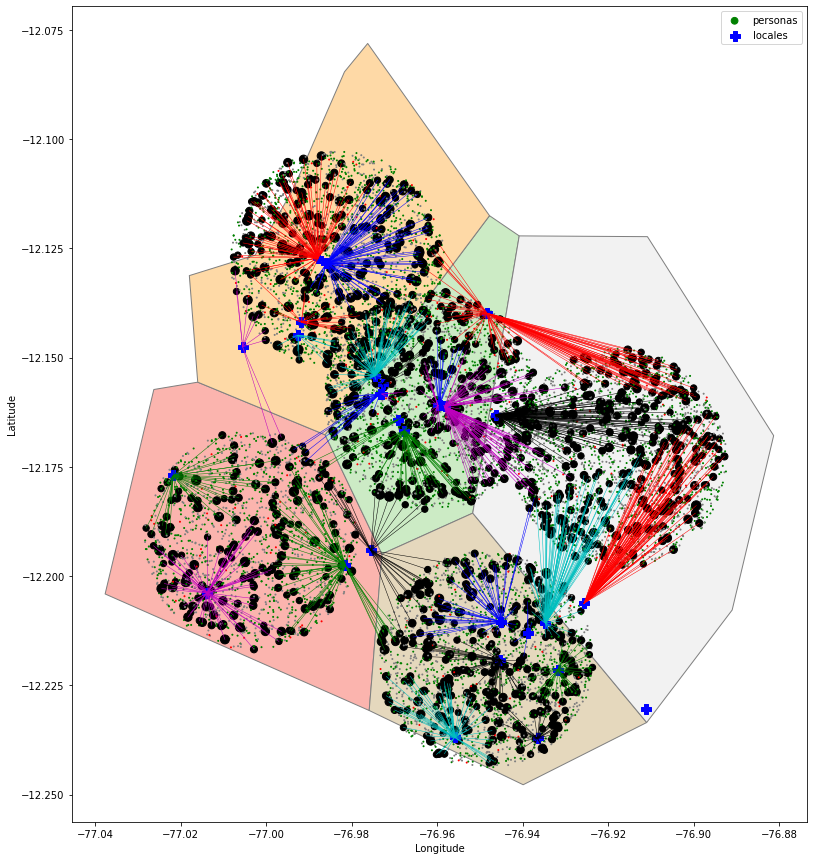

In [11]:
app.Draw(appSolver.__plotLines__)

# HEURISTICS

In [25]:
if __name__ == "__main__":

    heuristics_var = {
        "FIRST": cp_model.CHOOSE_FIRST, # 0
        "LOWEST_MIN": cp_model.CHOOSE_LOWEST_MIN, # 1
        "HIGHEST_MAX": cp_model.CHOOSE_HIGHEST_MAX, # 2
        "MIN_DOMAIN_SIZE": cp_model.CHOOSE_MIN_DOMAIN_SIZE, # 3
        "MAX_DOMAIN_SIZE": cp_model.CHOOSE_MAX_DOMAIN_SIZE # 4
    }
    heuristics_domain = {
        "MIN_VALUE": cp_model.SELECT_MIN_VALUE, # 0
        "MAX_VALUE": cp_model.SELECT_MAX_VALUE, # 1
        "LOWER_HALF": cp_model.SELECT_LOWER_HALF, # 2
        "UPPER_HALF": cp_model.SELECT_UPPER_HALF # 3

    }


    # DEF EXAMPLE
    app = AppLogic("/content/drive/MyDrive/topicos-dataset")
    # CONF REGIONS
    app.regions.SetDeparmento("LIMA")
    app.regions.SetProvincia("LIMA")
    ____selected____ = [False, False, False, False, False, False, True, False, False, False, False, False, \
                        False, False, False, False, False, False, False, False, False, False, False, False, \
                        False, False, False, False, False, False, False, False, True, False, False, False, \
                        False, False, False, True, False, True, True]
    app.regions.SetDistritos(____selected____)
    # CONF PEOPLE
    app.people.SetLocation(percentage=.005 * 0.5, radius=0.025)
    app.people.SetAge("50-59")
    app.people.SetDoses(2)
    app.people.SetInfected()
    # CONF HEALTH CENTERS
    app.hcs.SetCenters()
    app.hcs.AsSample()
    app.hcs.SetCapacity(app.people.total, exceed=0.25)

    appSolver = AppSolver(app)

    print(" "*20, end="")
    for nhd in heuristics_domain.keys():
        print(str(nhd) + " "*(20-len(str(nhd))), end="")
    print()
    for nhv, hv in heuristics_var.items():
        print(str(nhv) + " "*(20-len(str(nhv))), end="")
        for hd in heuristics_domain.values():
            try:
                _ = f"{appSolver.Solve_W_Heuristics(hv, hd):.7f}"
                print(_ + " "* (20-len(_)), end="")
            except:
                print("MAX REACHED"+ " "*4, end="")
        print()    

                    MIN_VALUE           MAX_VALUE           LOWER_HALF          UPPER_HALF          
FIRST               2.8779397           2.4940588           2.4422903           2.4902444           
LOWEST_MIN          2.5329731           2.4897647           2.5536120           2.5930071           
HIGHEST_MAX         2.5294487           2.5700417           2.6107159           2.7319939           
MIN_DOMAIN_SIZE     2.6984963           2.6172550           2.6153545           2.6061323           
MAX_DOMAIN_SIZE     2.5609019           2.6233368           2.6602201           2.6137502           
